In [3]:
# 라이브러리 불러오기
import torch
from torch import nn
from torch.utils.data import Dataset
import gluonnlp as nlp
import numpy as np
 
#kobert
from kobert_tokenizer import KoBERTTokenizer

# transformers
from transformers import BertModel

# GPU 사용시 필요
device = torch.device("cuda:0")

# 모델 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')
tok = tokenizer.tokenize
    
max_len = 64
batch_size = 32

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6, #클래스 수 조정
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
    
model = torch.load('model/kobert-v6.pt')

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         
    def __len__(self):
        return (len(self.labels))
    
def predict(sentence):
    dataset = [[sentence, '0']]
    test = BERTDataset(dataset, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, num_workers=0)
    model.eval()
    answer = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        for logits in out:
            logits = logits.detach().cpu().numpy()
            answer = np.argmax(logits)
    return answer

In [ ]:
emos = ('행복','불안','놀람', '슬픔','분노','중립')
def sa_demo(sentence):
    res = predict(sentence)
    print("문장에서 "+ emos[res] + "이(가) 느껴집니다.")

In [4]:
def getres(text):

    emos = ('행복','불안','놀람', '슬픔','분노','중립')
    res = {'행복':0,'불안':0,'놀람':0, '슬픔':0,'분노':0,'중립':0}

    for sentence in text:
        res[emos[predict(sentence)]] += 1
        
    return res

In [9]:
# 테스트
def getres_(text):

    emos = ('행복','불안','놀람', '슬픔','분노','중립')

    for sentence in text:
        
        res = emos[predict(sentence)]
        
        if res != '중립':
            print("{}    {}".format(res, sentence))
        

In [32]:
file_path = 'book/[슬픔]슬픈꼭두각시.txt'


# 파일 읽기
with open(file_path, 'r') as file:
    text = file.read()

# 2개 이상의 연속된 줄바꿈을 하나로 변경
modified_text = text.replace('\n\n', '\n')

# 결과를 다시 파일에 저장
with open('슬픈꼭두각시.txt', 'w') as file:
    file.write(modified_text)


In [114]:
import re
import pandas as pd

file_path = 'book/[슬픔]슬픈꼭두각시.txt'
file_path = 'book/[셜록홈즈]공포의 오렌지씨앗.txt'

file = open(file_path, 'r',encoding='UTF8')    #인코딩 안바꾸면 오류
raw_text = file.readlines()

#줄바꿈제거
textsum = '' 
for sentence in raw_text:
    sentence = sentence.replace("\n", "")
    textsum += sentence

#(한자) 제거    
textsum = re.sub('\([^)]*\)|[一-龥]', '', textsum)

textsum = textsum.replace('…', '...')

#문장 단위로 분리: . ”로 끝날때마다 묶어주기
text = []
s, e = 0, 0
isopen = False #쌍따옴표 안에 글자인지 확인

for i in range(len(textsum)-1):
    if textsum[i]=='“':
        isopen = True
        continue
        
    if (textsum[i]=='.' and textsum[i+1]!='”' and isopen==False) or textsum[i]=='”':
        e = i+1
        text.append(textsum[s:e].strip())
        s = e
        isopen = False
        
print(len(text), "문장")

res = getres(text)
res

537 문장


{'행복': 9, '불안': 9, '놀람': 25, '슬픔': 25, '분노': 19, '중립': 450}

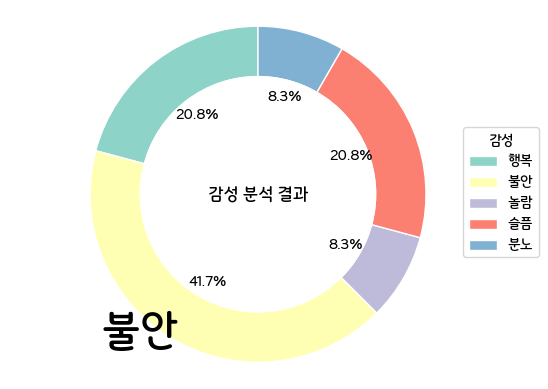

In [24]:
printvis(res)

In [112]:
# 테스트 감정 등장 순서
import re
import pandas as pd


file_path = 'book/헤밍웨이-노인과바다.txt'
file_path = 'book/[셜록홈즈]너도밤나무집.txt'


file = open(file_path, 'r',encoding='UTF8')    #인코딩 안바꾸면 오류
raw_text = file.readlines()

#줄바꿈제거
textsum = '' 
for sentence in raw_text:
    sentence = sentence.replace("\n", "")
    textsum += sentence

#(한자) 제거    
textsum = re.sub('\([^)]*\)|[一-龥]', '', textsum)

textsum = textsum.replace('…', '...')

#문장 단위로 분리: . ”로 끝날때마다 묶어주기
text = []
s, e = 0, 0
isopen = False #쌍따옴표 안에 글자인지 확인

for i in range(len(textsum)-1):
    if textsum[i]=='“':
        isopen = True
        continue
        
    if (textsum[i]=='.' and textsum[i+1]!='”' and isopen==False) or textsum[i]=='”':
        e = i+1
        text.append(textsum[s:e].strip())
        s = e
        isopen = False
        
print(len(text), "문장")
        
getres_(text)

508 문장
놀람    아침 식사를 마친 나와 홈즈는 베이커 거리에 있는 그의 방으로 가서 난로 옆에 앉아 있었다.
분노    홈즈는 신문 광고란을 잠자코 읽고 있다가 갑자기 무슨 생각이 났는지 꾸깃꾸깃 한 편지 한 통을 내게 내밀었다.
행복    옷차림은 수수했으나 단정하고 깨끗했으며, 얼굴표정이 밝고 매우 똑똑해 보이는 처녀였다.
행복    "홈즈는 이 아가씨가 마음에 쏙 들었는지 얼른 의자를 권했다.
행복    아주 훌륭합니다.
분노    ''그건 너무 심하군!'그 신사는 깜짝 놀란 듯이 두 팔을 쳐들고 이렇게 말했어요.
분노    올해 여섯 살 난 장난꾸러기지요.
슬픔    그분은 무척 실망한 표정으로 다음과 같이 말씀하시고는 돌아가시더군요.
행복    너도밤나무 집에서  제프로 루캐슬 - 이런 편지입니다.
불안    저는 일단 가기로 마음은 먹었지만 어쩐지 불안하고 초조해요.
행복    "헌터 양은 얼굴에 웃음을 띠고는 몇 번 이나 고맙다는 인사를 하고 돌아갔다.
행복    "나이는 어리지만 매우 침착한 아가씨로군.
놀람    "홈즈의 이 추측은 적중했다.
행복    홈즈는 한번 훑어보고는 내게 건네주었다.
불안    앞일이 막막함.
행복    다음날 아침 11시에 우리가 탄 열차는 윈체스터 시 근처를 달리고 있었다.
행복    호텔에서는 헌터 양이 먼저 와서 우리가 오기를 기다리고 있었다.
행복    헌터 양은 우리를 보자마자 활짝 웃으면서 말했다.
행복    와주셔서 대단히 고맙습니다.
슬픔    저는 어찌할 바를 모르고 쩔쩔매고 있었어요.
놀람    홈즈의 말이 끝나기도 전에 헌터 양이 이야기를 시작했다.
행복    루캐슬 씨의 너도밤나무 집은 정말 아름다운 곳이었어요.
행복    루캐슬 씨는 저녁때가 되어서야 제프로 부인과 아들을 만나게 해주셨어요.
놀람    ""저런! 아주 기발한 생각이군요.
놀람    그런데 어느새 부인께서 저의 행동을 눈치채셨는지 의자에서 벌떡 일어서더니 루캐슬 씨에게.
행복    ""들으면 들을수록 재미있군요.
분노  

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
print(font_list)

In [ ]:
fontpath = r'C:\Windows\Fonts\HMKMRHD.TTF'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)
print(plt.rcParams['font.family']) #적용됬는지 확인

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.pyplot as plt
import seaborn as sns

fontpath = r'C:\Windows\Fonts\HMKMRHD.TTF'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)

def printvis(res):

    # 중립은 그래프에서 빠지도록
    del res['중립']
    
    # 키와 값 리스트 추출
    labels = list(res.keys())
    sizes = list(res.values())
    
    # 원형 그래프 그리기
    fig1, ax1 = plt.subplots()

    # 가운데 부분을 뚤린 원형으로 설정
    wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성

    # 원형 그래프 그리기
    outer_colors = plt.cm.Set3(range(len(labels)))  # 바깥 부분 색상
    inner_colors = ['white'] * len(labels)  # 가운데 부분 색상

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=outer_colors, wedgeprops=wedgeprops)

    ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops)  # 가운데 뚤린 원형 추가

    # 가운데 부분에 텍스트 추가
    plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)

    # 가운데 뚤린 원형 그래프 출력
    plt.axis('equal')
    plt.show()
    
    #plt.savefig('res_image/vistemp.png', dpi=300, bbox_inches='tight')

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import font_manager
import seaborn as sns

fontpath = r'C:\Windows\Fonts\HMKMRHD.TTF'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)

def printvis(res):
    # 중립은 그래프에서 빠지도록
    del res['중립']

    # 키와 값 리스트 추출
    labels = list(res.keys())
    sizes = list(res.values())
    
    # 가장 큰 값을 가진 라벨의 인덱스 찾기
    max_index = sizes.index(max(sizes))

    # 원형 그래프 그리기
    fig1, ax1 = plt.subplots()

    # 가운데 부분을 뚤린 원형으로 설정
    wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  
    outer_colors = plt.cm.Set3(range(len(labels)))  
    inner_colors = ['white'] * len(labels)  

    # 원형 그래프의 텍스트 위치를 조정하기 위한 라벨 리스트 생성
    explode = [0] * len(labels)
    explode[max_index] = 0.2  # 가장 큰 값을 가진 라벨만 바깥으로 표시

    wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
            colors=outer_colors, wedgeprops=wedgeprops, explode=explode, pctdistance=0.85, textprops=dict(color="w"))
    
    ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops)

    # 라벨의 스타일과 위치를 조정
    for t in texts:
        t.set(size=10, color="black", va="center", ha="center")
    texts[max_index].set(position=(1.3, 0))  # 가장 큰 값을 가진 라벨의 위치 조정
    
    plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)

    plt.axis('equal')
    plt.show()


In [ ]:
#  font_manager 모듈에서 폰트 캐시를 삭제
from matplotlib import font_manager
font_manager._rebuild()

In [ ]:
# 위 방법이 안될 떄 캐시 파일을 직접 삭제
import matplotlib
print(matplotlib.get_cachedir())    #이 경로에서 json파일 삭제

In [99]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fontpath = r'C:\Users\KangIW\AppData\Local\Microsoft\Windows\Fonts\NPSfont_regular.ttf'
fontpath = r'NPSfont_regular.ttf'
font_name = fm.FontProperties(fname=fontpath, size=50).get_name()
plt.rc('font', family=font_name)

def printvis(res):
    # 중립은 그래프에서 빠지도록
    del res['중립']
    
    # 키값으로 딕셔너리를 정렬하고 첫번째, 두번째로 큰 키를 추출
    sorted_items = sorted(res.items(), key=lambda item: item[1], reverse=True)
    first_key, second_key = sorted_items[0][0], sorted_items[1][0]
    print(first_key, second_key)

    # 만약 가장 큰 키가 '놀람'이면 두번쨰 값을 디스플레이
    if first_key == '놀람':
        first_key = second_key
        
    # first_key의 인덱스 찾기
    index_of_first_key = list(res.keys()).index(first_key)       
     
    # 라벨 설정
    labels_for_display = [''] * len(res)
    labels_for_display[index_of_first_key] = first_key  
          
    # 원형 그래프 그리기
    _, ax1 = plt.subplots()

    # 가운데 부분을 뚤린 원형으로 설정
    wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성

    # 원형 그래프 그리기
    outer_colors = plt.cm.Set3(range(len(res)))  # 바깥 부분 색상
    inner_colors = ['white'] * len(res)  # 가운데 부분 색상
    

    # 원형 그래프에 labels 파라미터를 추가해서 바깥에 최대값을 갖는 키의 이름만 출력되도록 함
    wedges, texts, autotexts = ax1.pie(
        list(res.values()),
        labels=labels_for_display,  # <--- 이 부분을 수정함
        autopct='%1.1f%%', 
        startangle=90,
        colors=outer_colors, 
        wedgeprops=wedgeprops,
        labeldistance= 0.95 #그래프, 텍스트 거리
        )
    
    # 감정 글씨만 키우기
    for text in texts:
        text.set_fontsize(30)

    ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops)  # 가운데 뚤린 원형 추가
    
    # 범례 추가
    ax1.legend(wedges, list(res.keys()), title="감성", loc="best", bbox_to_anchor=(0.67, 1.35), ncol=2) #bbox_to_anchor: 범례 위치

    # 가운데 부분에 텍스트 추가
    plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=17)

    # 가운데 뚤린 원형 그래프 출력
    plt.axis('equal')
    plt.show()

놀람 슬픔


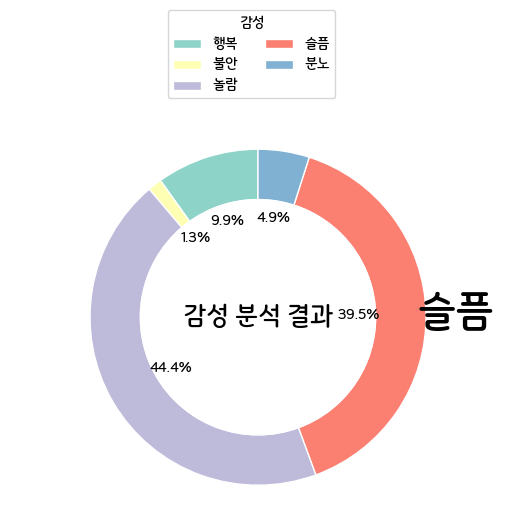

In [100]:
res = {'행복': 22, '불안': 3, '놀람': 99, '슬픔': 88, '분노': 11, '중립': 36}
printvis(res)

In [ ]:
import matplotlib.pyplot as plt

# 키와 값 리스트 추출
labels = list(res.keys())
sizes = list(res.values())

# 원형 그래프 그리기
fig1, ax1 = plt.subplots()

# 가운데 부분을 뚤린 원형으로 설정
wedgeprops = {'width': 0.3, 'edgecolor': 'white'}  # 가운데 부분 속성

# 원형 그래프 그리기
outer_colors = plt.cm.Set3(range(len(labels)))  # 바깥 부분 색상
inner_colors = ['white'] * len(labels)  # 가운데 부분 색상

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90,
        colors=outer_colors, wedgeprops=wedgeprops)

ax1.pie([1], radius=0.7, colors=inner_colors, wedgeprops=wedgeprops)  # 가운데 뚤린 원형 추가

# 가운데 부분에 텍스트 추가
plt.text(0, 0, '감성 분석 결과', ha='center', va='center', fontsize=12)


# 가운데 뚤린 원형 그래프 출력
plt.axis('equal')
plt.show()

In [ ]:
import pandas as pd

sample1 = pd.read_csv('sentiment-analysis/data/output.csv', names=["book1"])  #index_col=0 하면 안됨
sample1.sample(n=8)

In [ ]:
emos = ('행복','불안','놀람', '슬픔','분노','중립')
res = {'행복':0,'불안':0,'놀람':0, '슬픔':0,'분노':0,'중립':0}

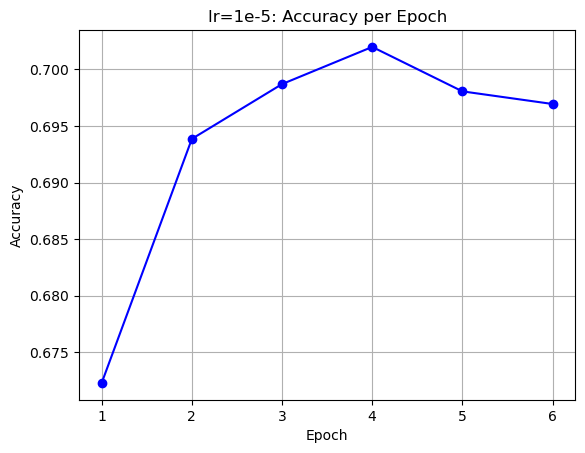

In [2]:
import matplotlib.pyplot as plt

# 정확도 리스트
accuracies = [
    0.6722982123510293,
    0.6938651137594799,
    0.6987066630552546,
    0.7019907908992417,
    0.6980633802816901,
    0.6969460996749729
]

# 에폭 번호 (0부터 시작하거나 1부터 시작하도록 조정할 수 있습니다)
epochs = range(1, len(accuracies)+1)

# 그래프 그리기
plt.plot(epochs, accuracies, marker='o', linestyle='-', color='blue')
plt.title('lr=1e-5: Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

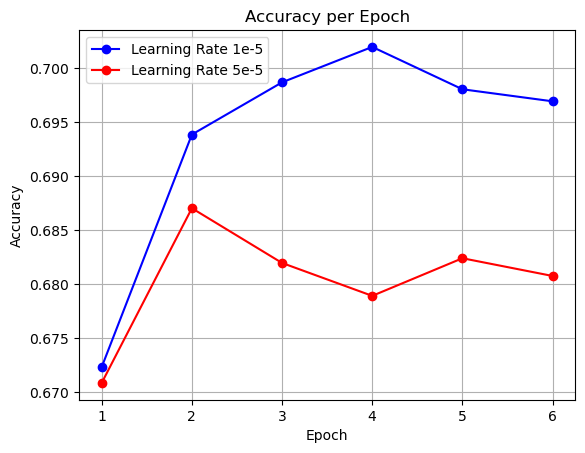

In [4]:
import matplotlib.pyplot as plt

# 첫 번째 정확도 리스트 (학습률 1e-5)
accuracies_1e_5 = [
    0.6722982123510293,
    0.6938651137594799,
    0.6987066630552546,
    0.7019907908992417,
    0.6980633802816901,
    0.6969460996749729
]

# 두 번째 정확도 리스트 (학습률 3e-5)
accuracies_3e_5 = [
    0.6708301158301158,
    0.6870318532818533,
    0.6819546332046331,
    0.6789044401544401,
    0.6823938223938223,
    0.6807480694980695
]

# 에폭 번호
epochs = range(1, len(accuracies_1e_5)+1)

# 첫 번째 그래프 그리기 (학습률 1e-5)
plt.plot(epochs, accuracies_1e_5, marker='o', linestyle='-', color='blue', label='Learning Rate 1e-5')

# 두 번째 그래프 그리기 (학습률 3e-5)
plt.plot(epochs, accuracies_3e_5, marker='o', linestyle='-', color='red', label='Learning Rate 5e-5')

# 그래프 제목과 축 레이블 설정
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# 범례 추가
plt.legend()

# 그리드 추가
plt.grid(True)

# 그래프 표시
plt.show()

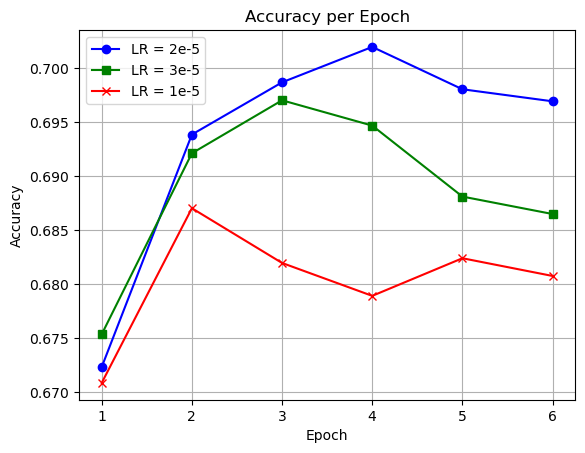

In [8]:
import matplotlib.pyplot as plt

# 첫 번째 정확도 리스트 (학습률 1e-5)
accuracies_1e_5 = [
    0.6722982123510293,
    0.6938651137594799,
    0.6987066630552546,
    0.7019907908992417,
    0.6980633802816901,
    0.6969460996749729
]

# 두 번째 정확도 리스트 (학습률 3e-5)
accuracies_3e_5 = [
    0.6708301158301158,
    0.6870318532818533,
    0.6819546332046331,
    0.6789044401544401,
    0.6823938223938223,
    0.6807480694980695
]

# 세 번째 정확도 리스트 (학습률 2e-5)
accuracies_2e_5 = [
    0.6753365087935822,
    0.6921282011724776,
    0.6970408438753471,
    0.6946929959888923,
    0.6881122724467758,
    0.6864924020364086
]

# 에폭 번호
epochs = range(1, len(accuracies_1e_5)+1)

# 첫 번째 그래프 그리기 (학습률 1e-5)
plt.plot(epochs, accuracies_1e_5, marker='o', linestyle='-', color='blue', label='LR = 2e-5')

# 두 번째 그래프 그리기 (학습률 2e-5)
plt.plot(epochs, accuracies_2e_5, marker='s', linestyle='-', color='green', label='LR = 3e-5')

# 세 번째 그래프 그리기 (학습률 3e-5)
plt.plot(epochs, accuracies_3e_5, marker='x', linestyle='-', color='red', label='LR = 1e-5')

# 그래프 제목과 축 레이블 설정
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# 범례 추가
plt.legend()

# 그리드 추가
plt.grid(True)

# 그래프 표시
plt.show()